In [1]:
import re
import numpy as np
import sys
from peft import LoraConfig, get_peft_model
sys.path.append("/home/tsuchida/KLab_MultiModalModel/tsuchida_workdir/..")

from PIL import Image
import torch

/opt/conda/envs/kmmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def find_loc_index_combinations(s):  
    # 正規表現のパターンを更新: <loc_数字>の後に物体の名前も取得できるようにする
    pattern = r'([^<]+)<loc_(\d+)><loc_(\d+)>'
    
    # Find all matches in the given string  
    matches = re.findall(pattern, s)  
      
    valid_combinations = []  
      
    for match in matches:
        label,x_val, y_val = match

        valid_combinations.append((label, int(x_val), int(y_val)))
      
    return valid_combinations



In [4]:
def get_box_coords_from_index(P, ul_idx, lr_idx):  
    """  
    Given a grid of length P and the indices of the upper-left and lower-right corners of a bounding box,  
    returns the normalized coordinates of the bounding box, in the form [x1, y1, x2, y2].  
      
    Args:  
    - P (int): the length of the grid  
    - ul_idx (int): the index of the grid cell that corresponds to the upper-left corner of the bounding box  
    - lr_idx (int): the index of the grid cell that corresponds to the lower-right corner of the bounding box  
      
    Returns:  
    - box_coords (np.array of shape (4,)): the normalized coordinates of the bounding box, in the form [x1, y1, x2, y2]  
    """  
    # Compute the size of each cell in the grid  
    cell_size = 1.0 / P  
      
    # Compute the x and y indices of the upper-left and lower-right corners of the bounding box  
    ul_x = ul_idx % P  
    ul_y = ul_idx // P  
      
    lr_x = lr_idx % P  
    lr_y = lr_idx // P  
      
    # Compute the normalized coordinates of the bounding box  
    if ul_idx == lr_idx:  
        x1 = ul_x * cell_size  
        y1 = ul_y * cell_size  
        x2 = lr_x * cell_size + cell_size  
        y2 = lr_y * cell_size + cell_size  
    elif ul_x == lr_x or ul_y == lr_y:  
        x1 = ul_x * cell_size  
        y1 = ul_y * cell_size  
        x2 = lr_x * cell_size + cell_size  
        y2 = lr_y * cell_size + cell_size  
    else:  
        x1 = ul_x * cell_size + cell_size / 2  
        y1 = ul_y * cell_size + cell_size / 2  
        x2 = lr_x * cell_size + cell_size / 2  
        y2 = lr_y * cell_size + cell_size / 2  
      
    return np.array([x1, y1, x2, y2])

In [5]:
def decode_bbox_from_caption(caption, quantized_size=40, **kwargs):
    
    valid_combinations = find_loc_index_combinations(caption)
    entity_names = list(map(lambda x: x[0], valid_combinations))
    patch_index_coords = list(map(lambda pair: get_box_coords_from_index(quantized_size, pair[1], pair[2]), valid_combinations))
    collect_entity_location = []
    for entity_name, patch_index_coord in zip(entity_names, patch_index_coords):
        collect_entity_location.append([entity_name,] + patch_index_coord.tolist())
    
    return collect_entity_location

##### 動作確認

In [6]:
if __name__ == "__main__":
    
    caption = "man self<loc_3><loc_1598> car<loc_1><loc_1590>" 
    print(find_loc_index_combinations(caption))
    print(decode_bbox_from_caption(caption))

[('man self', 3, 1598), (' car', 1, 1590)]
[['man self', 0.08750000000000001, 0.0125, 0.9625, 0.9875], [' car', 0.037500000000000006, 0.0125, 0.7625, 0.9875]]


In [7]:
import os
from copy import deepcopy

import pandas as pd
import torch
from PIL import Image
from torchvision.transforms import ToTensor
from data.dataset_loader import DatasetLoader

#存在しない画像を除外するためのリスト
dropimageidlist =["7f1934f5884fad79","429019e83c1c2c94","4f818c006da84c9e","5b86e93f8654118a","673d74b7d39741c3","6dcd3ce37a17f2be","805baf9650a12710"
                   ,"98ac2996fc46b56d","a46a248a39f2d97c","9316d4095eab6d10","9ee38bb2e69da0ac","37625d59d0e0782a"]

class OpenImageDataset(DatasetLoader):
    """openimageのdetectionデータセット
    """    
    def __init__(self,data_dir:str="/data/dataset/openimage/",phase:str="train"):
        super().__init__()        
        if phase=="val":
            phase = "validation"

        with open(os.path.join(data_dir,"tsv",f"{phase}_40_dec.tsv")) as f:
            items = f.read()

        items = items.split("\n")
        items = [item.split("\t") for item in items]
        items = items[1:10]
        items = [item for item in items if len(item)==2]
        self.tgt_texts = [item[1] for item in items]
        self.src_texts = ["What objects are in the image?"]*len(items)
        self.images = [os.path.join(data_dir,f"{phase}_256_png",f"{item[0]}.png") for item in items]

        #dropimageidlistに含まれる画像と対応するテキストを除外する
        for drop_id in dropimageidlist:
            drop_path = os.path.join(data_dir,f"{phase}_256_png",f"{drop_id}.png")
            while drop_path in self.images:
                drop_index = self.images.index(drop_path)
                self.tgt_texts.pop(drop_index)
                self.src_texts.pop(drop_index)
                self.images.pop(drop_index)
        
        

In [8]:
train_dataset = OpenImageDataset(data_dir="/home/dataset/openimage/", phase="train")
val_dataset = OpenImageDataset(data_dir="/home/dataset/openimage/", phase="val")

In [9]:
from transformers import AutoTokenizer
from torchvision import transforms
# src_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256)
src_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small", model_max_length=256, use_fast=True)

# tgt_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256, use_fast=True, extra_ids=0, additional_special_tokens =[f"<extra_id_{i}>" for i in range(100)] + [f"<loc_{i}>" for i in range(1000)] + [f"<img_{i}>" for i in range(args.image_vocab_size)])
resize=256
src_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
])
tgt_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
])

In [10]:
import numpy as np
def custom_to_pil(x):
  x = x.detach().cpu().numpy()
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)

  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_data(dataset, idx=10):
    src_image, tgt_image, src_text, tgt_text = dataset[idx]
    tgt_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small", model_max_length=256, use_fast=True, extra_ids=0, additional_special_tokens =[f"<loc_{i}>" for i in range(1600)])

    with torch.no_grad():
        src_image = src_image.unsqueeze(0).to(device)
        print('src_text:', src_text)
        print('tgt_text:', tgt_text)
        # src_text = src_tokenizer(src_text, padding="longest", max_length=256, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        # tgt_text = tgt_tokenizer(tgt_text, padding="longest", max_length=256, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        # print(src_text, tgt_text)

        img = custom_to_pil(src_image[0])
        
        img_width, img_height = img.size
        fig, ax = plt.subplots(1)
        ax.imshow(img)
        bboxes =[]
        find_loc_index_combinations(tgt_text)
        bboxes = decode_bbox_from_caption(tgt_text)
        
        
        # 各bboxを描画
        for items in bboxes:
            # bboxの座標を実際の画像サイズにスケーリング
            label,x1, y1, x2, y2 = items
            x1 = x1 * img_width
            y1 = y1 * img_height
            x2 = x2 * img_width
            y2 = y2 * img_height
            width = x2 - x1
            height = y2 - y1
            
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
            # bboxの上にラベル（物体の名前）を表示
            plt.text(x1, y1, label, bbox=dict(facecolor='red', alpha=0.5), fontsize=9, color='white')
    

        plt.show()
        # display(custom_to_pil(src_image[0]))

src_text: What objects are in the image?
tgt_text: Cake<loc_1060><loc_1556> Dairy Product<loc_1060><loc_1516> Pastry<loc_1020><loc_1555> Person<loc_200><loc_887> Person<loc_1080><loc_1450> Person<loc_285><loc_932> Person<loc_1009><loc_1456> Person<loc_370><loc_613> Person<loc_412><loc_494> Person<loc_176><loc_756> Table<loc_1362><loc_1539> Table<loc_731><loc_958> Table<loc_532><loc_742>


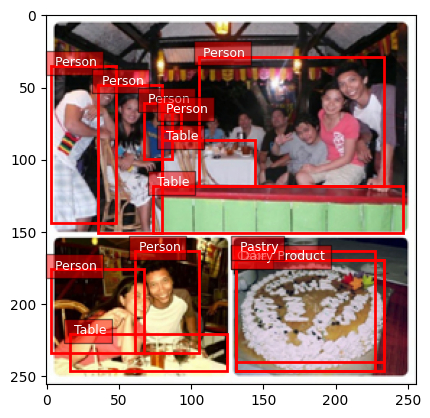

src_text: What objects are in the image?
tgt_text: Building<loc_1400><loc_1522> Building<loc_280><loc_1124> Building<loc_1402><loc_1485> Building<loc_1325><loc_1490> Building<loc_1184><loc_1558> Building<loc_1071><loc_1195> Building<loc_673><loc_1398> Window<loc_837><loc_918>


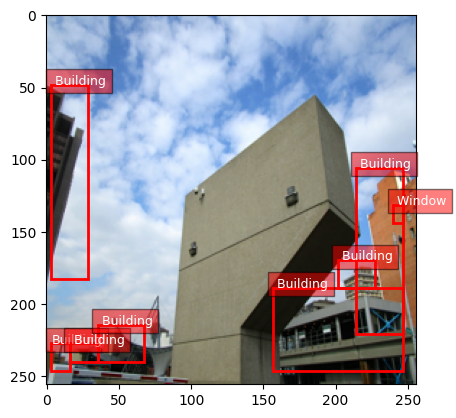

src_text: What objects are in the image?
tgt_text: Person<loc_360><loc_1528> Person<loc_365><loc_1540> Person<loc_645><loc_849> Person<loc_423><loc_1551> Person<loc_384><loc_1558> Suit<loc_560><loc_1527> Suit<loc_663><loc_1551> Tie<loc_724><loc_926> Tie<loc_786><loc_1188>


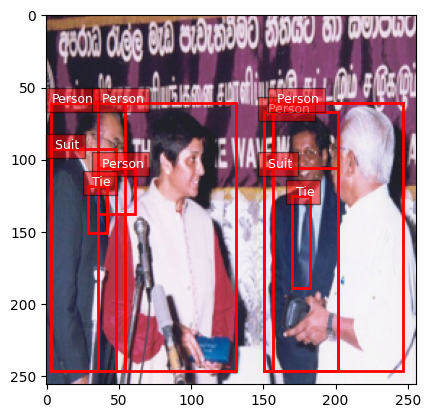

In [12]:
show_data(train_dataset, idx=0)
show_data(train_dataset, idx=1)
show_data(train_dataset, idx=5)

##### 学習したものを可視化

In [15]:
import argparse
from models.model import MyModel
args = argparse.Namespace(
    # Model setting
    image_model_name="microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft",
    image_model_train=False,
    language_model_name="google/flan-t5-small",
    transformer_model_name="google/flan-t5-base",
    ffn=True,
    phase = "train",
    transformer_d_model=768,
    transformer_d_ff=3072,
    transformer_d_kv=64,
    transformer_num_heads=12,
    transformer_num_layers=2,
    transformer_num_decoder_layers=12,
    image_vocab_size=16384,
    loc_vocab_size=1600,
    vae_ckpt_path="checkpoints/vqgan.pt",
    max_source_length=256,
    max_target_length=256,
    # Train setting
    pretrain="train", 
    # Dir setting
    root_dir="/home/dataset/",
    result_dir="results/",
    loss = "CrossEntropy",
    loc_learn = "train",
    float_type = 'bfloat16',
    lora_r = 16,
    lora_alpha = 16,
    lora_dropout = 0.1,
    lora_bias = "none"
)



In [24]:
import torch

weights = torch.load("/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/lora/openimage/enc2_dec12/epoch_10.pth")
def inspect_nested_dict(nested_dict, prefix=''):
    for key, value in nested_dict.items():
        if isinstance(value, dict):  # もしvalueが辞書の場合、さらに中身を調査
            inspect_nested_dict(value, prefix=prefix + key + '.')
        else:
            print(prefix + key, type(value))

# メインのstate_dictに対して関数を実行
inspect_nested_dict(weights)

import matplotlib.pyplot as plt

layer_weights = weights['transformer']  # キー名を適切に変更する必要があります
plt.hist(layer_weights.cpu().numpy().flatten(), bins=100)
plt.xlabel('Weight values')
plt.ylabel('Number of weights')
plt.show()

transformer.shared.weight <class 'torch.Tensor'>
transformer.encoder.original_module.embed_tokens.weight <class 'torch.Tensor'>
transformer.encoder.original_module.block.0.layer.0.SelfAttention.q.weight <class 'torch.Tensor'>
transformer.encoder.original_module.block.0.layer.0.SelfAttention.k.weight <class 'torch.Tensor'>
transformer.encoder.original_module.block.0.layer.0.SelfAttention.v.weight <class 'torch.Tensor'>
transformer.encoder.original_module.block.0.layer.0.SelfAttention.o.weight <class 'torch.Tensor'>
transformer.encoder.original_module.block.0.layer.0.SelfAttention.relative_attention_bias.weight <class 'torch.Tensor'>
transformer.encoder.original_module.block.0.layer.0.layer_norm.weight <class 'torch.Tensor'>
transformer.encoder.original_module.block.0.layer.1.DenseReluDense.wi_0.weight <class 'torch.Tensor'>
transformer.encoder.original_module.block.0.layer.1.DenseReluDense.wi_1.weight <class 'torch.Tensor'>
transformer.encoder.original_module.block.0.layer.1.DenseReluDe

AttributeError: 'collections.OrderedDict' object has no attribute 'cpu'

In [31]:
model = MyModel(args).to(device)

lora_config = LoraConfig(
    r=args.lora_r,
    lora_alpha=args.lora_alpha,
    target_modules=[
            f"transformer.decoder.block.{i}.layer.0.SelfAttention.{endpoint}" 
            for i in range(args.transformer_num_decoder_layers)
            for endpoint in ["q", "k", "v"]
        ] + [
            f"transformer.decoder.block.{i}.layer.1.EncDecAttention.{endpoint}"
            for i in range(args.transformer_num_decoder_layers)
            for endpoint in ["q", "k", "v"]
        ],
    lora_dropout=args.lora_dropout,
    bias=args.lora_bias,
    modules_to_save=["transformer.encoder",
                    "transformer.lm_head",
                    "language_ffn",
                    "image_ffn"],
    )
model = get_peft_model(model, lora_config)
# print(model)
# 読み込みたい重みのパスを指定
# path = "/home/tsuchida/KLab_MultiModalModel/results/pretrain_claa/imagenet/enc2_dec1/best.pth"
# path = "/home/tsuchida/KLab_MultiModalModel/tsuchida_workdir/freeze.pth"
# path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/openimage/enc2_dec12/epoch_30.pth"
# path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/lora/openimage/enc2_dec12/epoch_30.pth"
# path = "/home/tsuchida/KLab_MultiModalModel/results/loc/lora/bf16/qkv/1e-5/openimage/1e-5lambda/enc2_dec12/epoch_40.pth"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/scratch/openimage/enc2_dec12/epoch_40.pth"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/scratch/openimage/enc2_dec12/best.pth"
tgt_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=args.max_target_length, use_fast=True, extra_ids=0, additional_special_tokens =[f"<loc_{i}>" for i in range(args.loc_vocab_size)])
model.transformer.resize_token_embeddings(len(tgt_tokenizer))

# def adjust_keys(state_dict):
#     new_state_dict = {}
#     for k, v in state_dict.items():
#         # "original_module"接頭語がある場合は無視
#         if "original_module" or "lora_B.default" in k:
#             continue
        
#         # "modules_to_save.default"を取り除く
#         if "encoder.modules_to_save.default" in k:
#             new_key = k.replace("modules_to_save.default.", "")
            
#         # "lm_head.lora_A.default.weight" から "lora_A.default" を取り除く
#         elif "lm_head.lora_A.default.weight" in k:
#             new_key = k.replace("lora_A.default.", "")
            
#         # 上記の条件に一致しないキーはそのまま保持
#         else:
#             new_key = k
        
#         new_state_dict[new_key] = v
    
#     return new_state_dict

# # state_dictのキーを調整
# loaded_state_dict = torch.load(path)
# adjusted_state_dict = adjust_keys(loaded_state_dict)
# model.load_state_dict(adjusted_state_dict)

model.load(result_name=path)
print(model)
model.eval()

T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "max_length": 256,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 2,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 300,
    

MyModel(
  (language_model): T5EncoderModel(
    (shared): Embedding(32128, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=384, bias=False)
                (k): Linear(in_features=512, out_features=384, bias=False)
                (v): Linear(in_features=512, out_features=384, bias=False)
                (o): Linear(in_features=384, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 6)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedActDense(
                (wi_0): Linear(in_features=512, out_features=1024, bias=False)
                (wi_1): Linear(in_featur

In [41]:
def show_result(dataset, idx=10):
    src_image, tgt_image, src_text, tgt_text = dataset[idx]
    with torch.no_grad():
        src_image = src_image.unsqueeze(0).to(device)
        tgt_text2 = tgt_text
        print('src_text:', src_text)
        print('tgt_text:', tgt_text)
        src_text = src_tokenizer(src_text, padding="longest", max_length=args.max_source_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        tgt_text = tgt_tokenizer(tgt_text, padding="longest", max_length=args.max_target_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        # print(src_text, tgt_text)

        # display(custom_to_pil(src_image[0]))
        src_attention_masks = torch.ones_like(src_text, device=device, dtype=torch.bool)
        src_attention_masks[src_text == 0] = 0
        tgt_attention_masks = torch.ones_like(tgt_text, device=device, dtype=torch.bool)
        tgt_attention_masks[tgt_text == 0] = 0
        preds = model(src_image, src_text, src_attention_masks, tgt_text, tgt_attention_masks,return_loss=False)
        preds = tgt_tokenizer.batch_decode(preds[:,1:-1])
        print('pred:', preds[0])
        print(type(preds))
        img = custom_to_pil(src_image[0])
        
        img_width, img_height = img.size
        fig, ax = plt.subplots(1)
        ax.imshow(img)
        bboxes =[]
        find_loc_index_combinations(preds[0])
        bboxes = decode_bbox_from_caption(preds[0])
        
        tgt_box =[]
        find_loc_index_combinations(tgt_text2)
        tgt_box = decode_bbox_from_caption(tgt_text2)
        
        # 各bboxを描画
        for item in tgt_box:
            # bboxの座標を実際の画像サイズにスケーリング
            label,x1, y1, x2, y2 = item
            x1 = x1 * img_width
            y1 = y1 * img_height
            x2 = x2 * img_width
            y2 = y2 * img_height
            width = x2 - x1
            height = y2 - y1
            
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            
            # bboxの上にラベル（物体の名前）を表示
            plt.text(x1, y1, label, bbox=dict(facecolor='green', alpha=0.5), fontsize=9, color='white')
        
        for items in bboxes:
            # bboxの座標を実際の画像サイズにスケーリング
            label,x1, y1, x2, y2 = items
            x1 = x1 * img_width
            y1 = y1 * img_height
            x2 = x2 * img_width
            y2 = y2 * img_height
            width = x2 - x1
            height = y2 - y1
            
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
            # bboxの上にラベル（物体の名前）を表示
            plt.text(x1, y1, label, bbox=dict(facecolor='red', alpha=0.5), fontsize=9, color='white')
    
        

        plt.show()
        # preds = src_tokenizer.batch_decode(output[:,1:-1])


src_text: What objects are in the image?
tgt_text: Cake<loc_1060><loc_1556> Dairy Product<loc_1060><loc_1516> Pastry<loc_1020><loc_1555> Person<loc_200><loc_887> Person<loc_1080><loc_1450> Person<loc_285><loc_932> Person<loc_1009><loc_1456> Person<loc_370><loc_613> Person<loc_412><loc_494> Person<loc_176><loc_756> Table<loc_1362><loc_1539> Table<loc_731><loc_958> Table<loc_532><loc_742>
pred: Clothing<loc_200><loc_764> Clothing<loc_1040><loc_1531> Clothing<loc_403><loc_687> Clothing<loc_406><loc_650> Clothing<loc_408><loc_652> Clothing<loc_410><loc_614> Clothing<loc_452><loc_656> Clothing<loc_454><loc_657> Clothing<loc_497><loc_660> Clothing<loc_459><loc_622> Clothing<loc_501><loc_664> Clothing<loc_463><loc_626> Clothing<loc_425><loc_669> Clothing<loc_387><loc_672> Clothing<loc_390><loc_715> Clothing<loc_312><loc_798> Girl<loc_960><loc_1532> Girl<loc_286><loc_691> Girl<loc_331><loc_655> Girl<loc_375><loc_618> Girl<loc_378><loc_621> Girl<loc_381><loc_625> Girl<loc_344><loc_588> Girl<loc

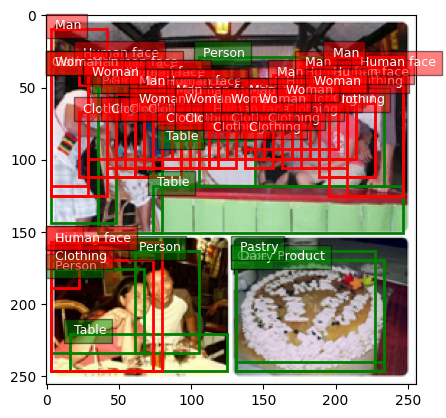

src_text: What objects are in the image?
tgt_text: Building<loc_1400><loc_1522> Building<loc_280><loc_1124> Building<loc_1402><loc_1485> Building<loc_1325><loc_1490> Building<loc_1184><loc_1558> Building<loc_1071><loc_1195> Building<loc_673><loc_1398> Window<loc_837><loc_918>
pred: Building<loc_0><loc_1558>
<class 'list'>


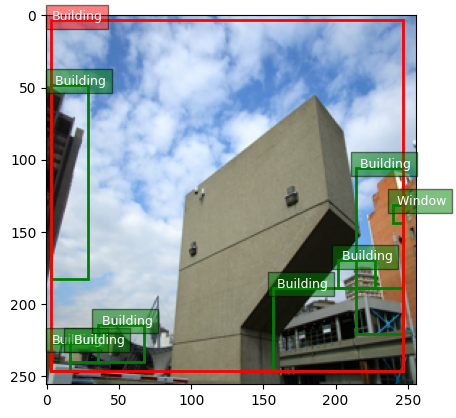

src_text: What objects are in the image?
tgt_text: Person<loc_360><loc_1528> Person<loc_365><loc_1540> Person<loc_645><loc_849> Person<loc_423><loc_1551> Person<loc_384><loc_1558> Suit<loc_560><loc_1527> Suit<loc_663><loc_1551> Tie<loc_724><loc_926> Tie<loc_786><loc_1188>
pred: Clothing<loc_560><loc_1526> Clothing<loc_645><loc_1534> Clothing<loc_692><loc_1541> Clothing<loc_701><loc_1550> Clothing<loc_669><loc_1558> Man<loc_360><loc_1527> Man<loc_404><loc_1533> Man<loc_451><loc_1540> Man<loc_460><loc_1550> Man<loc_387><loc_1558> Microphone<loc_856><loc_1180> Microphone<loc_866><loc_1150>
<class 'list'>


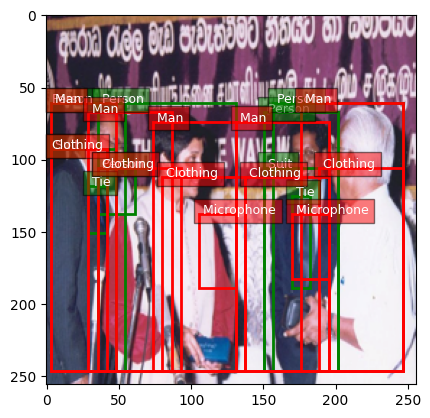

src_text: What objects are in the image?
tgt_text: Fixed-wing aircraft<loc_80><loc_1277>
pred: Fixed-wing aircraft<loc_0><loc_1238>
<class 'list'>


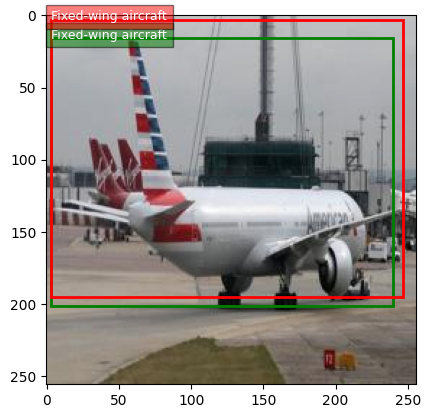

src_text: What objects are in the image?
tgt_text: Food<loc_0><loc_1599> Fruit<loc_1045><loc_1127> Fruit<loc_448><loc_529> Fruit<loc_769><loc_851> Fruit<loc_849><loc_931> Fruit<loc_1009><loc_1091> Fruit<loc_569><loc_691> Fruit<loc_929><loc_1051> Fruit<loc_930><loc_1011> Fruit<loc_531><loc_653> Fruit<loc_252><loc_374> Fruit<loc_933><loc_1054> Fruit<loc_1013><loc_1135> Fruit<loc_934><loc_1016> Fruit<loc_574><loc_983> Fruit<loc_375><loc_457> Fruit<loc_1096><loc_1218> Fruit<loc_936><loc_1059> Fruit<loc_1136><loc_1258> Fruit<loc_297><loc_783> Fruit<loc_1021><loc_1103> Fruit<loc_703><loc_825> Fruit<loc_464><loc_586> Fruit<loc_824><loc_946> Fruit<loc_1104><loc_1226> Fruit<loc_224><loc_306> Fruit<loc_466><loc_548> Fruit<loc_268><loc_390>
pred: Fruit<loc_0><loc_1558> Fruit<loc_0><loc_1558> Fruit<loc_9><loc_132> Fruit<loc_12><loc_95> Fruit<loc_15><loc_97> Fruit<loc_16><loc_98> Fruit<loc_17><loc_99> Fruit<loc_19><loc_60> Fruit<loc_19><loc_101> Fruit<loc_19><loc_101> Fruit<loc_22><loc_104> Fruit<l

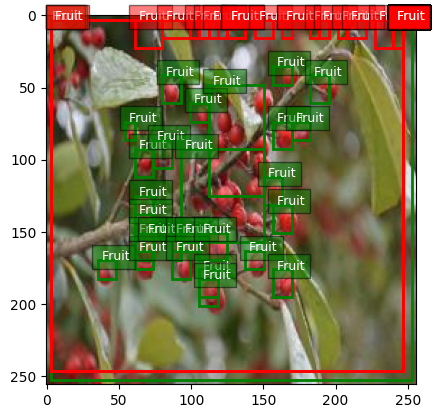

src_text: What objects are in the image?
tgt_text: Dog<loc_168><loc_1467>
pred: Dog<loc_52><loc_1469>
<class 'list'>


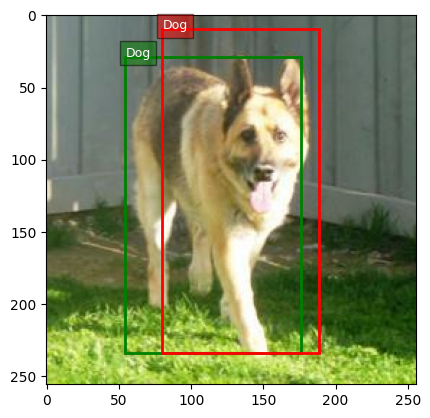

In [42]:
show_result(train_dataset, idx=0)
show_result(train_dataset, idx=1)
show_result(train_dataset, idx=5)
show_result(val_dataset, idx=0)
show_result(val_dataset, idx=1)
show_result(val_dataset, idx=5)